In [2]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from typing import List



In [3]:
data = pd.read_csv("../Data/FPL_data_24_26_untidy.csv")

In [4]:
data.rename(columns={"event_points" : "y_points"}, inplace=True)

In [5]:
data.isna().mean()[data.isna().mean()>0]

chance_of_playing_next_round            0.340307
chance_of_playing_this_round            0.353977
now_cost_rank_type                      0.127641
cost_change_event_fall                  0.127641
cost_change_start_fall                  0.127641
selected_rank_type                      0.127641
points_per_game                         0.127641
points_per_game_rank                    0.127641
points_per_game_rank_type               0.127641
form_rank                               0.127641
form_rank_type                          0.127641
dreamteam_count                         0.127641
expected_goals_per_90                   0.127641
expected_assists_per_90                 0.127641
expected_goal_involvements_per_90       0.127641
expected_goals_conceded_per_90          0.127641
influence_rank                          0.127641
influence_rank_type                     0.127641
creativity_rank                         0.127641
creativity_rank_type                    0.127641
threat_rank         

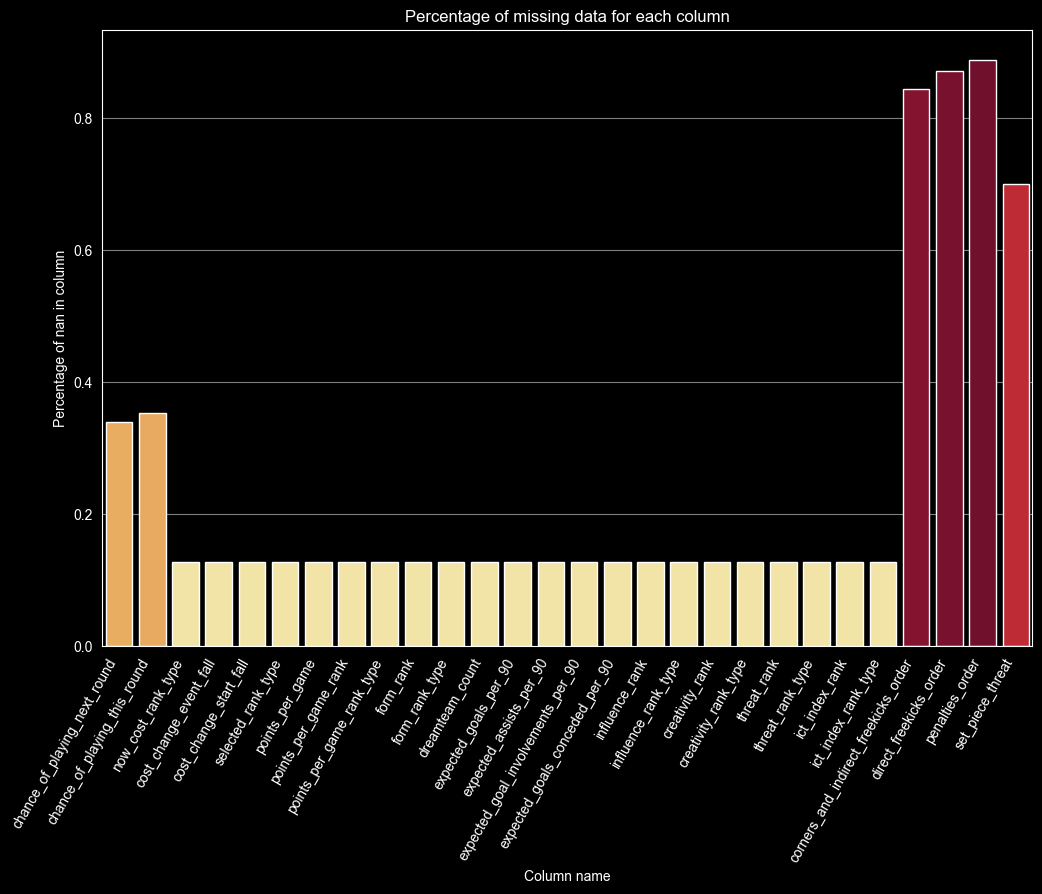

In [6]:
plt.figure(figsize=(12, 8))
s = data.isna().mean()
s = s[s > 0]

sns.barplot(x=s.index, y=s, hue=s.index, legend=False, palette=list(plt.cm.YlOrRd((s / s.max()))))
plt.xlabel("Column name")
plt.ylabel("Percentage of nan in column")
plt.title("Percentage of missing data for each column")

plt.xticks(rotation=60, ha='right')
plt.grid(axis='y', alpha=0.5);

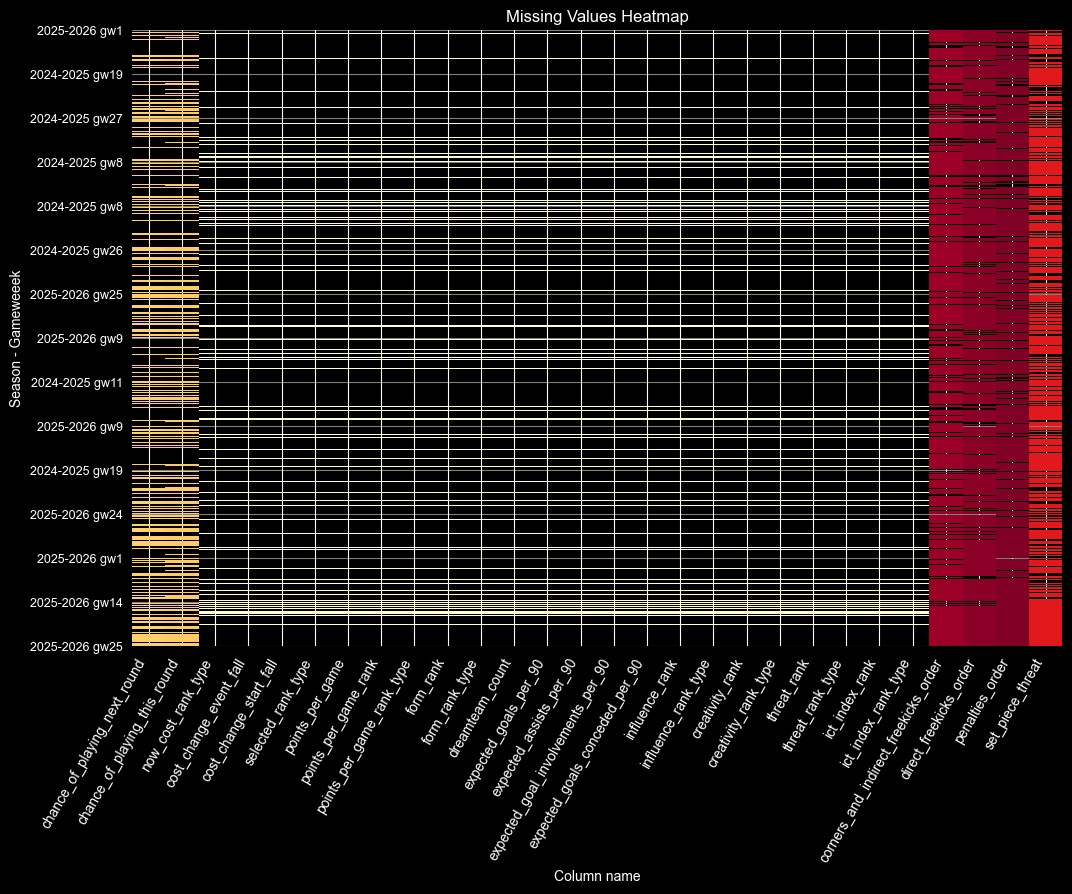

In [7]:
d = data.loc[:, data.isna().any()]
labels = data['season'].astype(str) + " gw" + data['gw'].astype(str)

plt.figure(figsize=(12, 8))
sns.heatmap(d.isna() * d.isna().mean(), mask=d.notna(), cmap='YlOrRd',
            cbar=False, yticklabels=False)

plt.title("Missing Values Heatmap")
plt.xticks(rotation=60, ha='right')

n_ticks = 15
y_positions = np.linspace(0, d.shape[0]-1, n_ticks)

plt.yticks(y_positions, labels.iloc[y_positions.astype(int)], fontsize=9)
plt.ylabel("Season - Gameweeek")
plt.xlabel("Column name")

plt.grid(axis='y', alpha=0.5)

### Statusy Zawodników
Poniższe skróty pochodzą bezpośrednio z pola `status` w oficjalnym API Fantasy Premier League.

| Kod | Pełna nazwa | Znaczenie i opis |
| :---: | :--- | :--- |
| **`a`** | **Available** . Zawodnik jest zdrowy i gotowy do gry. Nie posiada żadnych flag. Szansa na grę wynosi zazwyczaj **100%**. |
| **`d`** | **Doubtful** . Zawodnik posiada drobny uraz lub chorobę (żółta/pomarańczowa flaga). Szansa na grę waha się zazwyczaj między **25% a 75%**. |
| **`i`** | **Injured** . Zawodnik ma potwierdzoną kontuzję (czerwona flaga). Szansa na grę w bieżącej rundzie jest bliska **0%**, ale system może przewidywać powrót w następnej. |
| **`s`** | **Suspended** . Pauza dyscyplinarna za czerwoną kartkę lub limit żółtych kartek. Gracz jest niedostępny w tej kolejce, ale zazwyczaj wraca w następnej. |
| **`n`** | **Ineligible**. Najczęściej dotyczy graczy **wypożyczonych**, którzy zgodnie z przepisami Premier League nie mogą zagrać przeciwko swojemu klubowi macierzystemu. |
| **`u`** | **Unavailable** . Kategoria dla graczy, którzy opuścili klub, są na urlopach okolicznościowych lub zostali trwale odsunięci od składu. Ryzyko braku gry jest **bardzo wysokie**. |

In [8]:
data.status.unique()

<StringArray>
['a', 'i', 'd', 's', 'n', 'u']
Length: 6, dtype: str

In [9]:
change_of_playing = data[["status", "chance_of_playing_next_round", "chance_of_playing_this_round"]].groupby("status").mean()
change_of_playing

,chance_of_playing_next_round,chance_of_playing_this_round
status,,
a,82.892743,81.284245
d,67.058166,83.360129
i,0.000000,81.055901
n,0.000000,91.129032
s,0.000000,86.764706
u,0.000000,12.500000


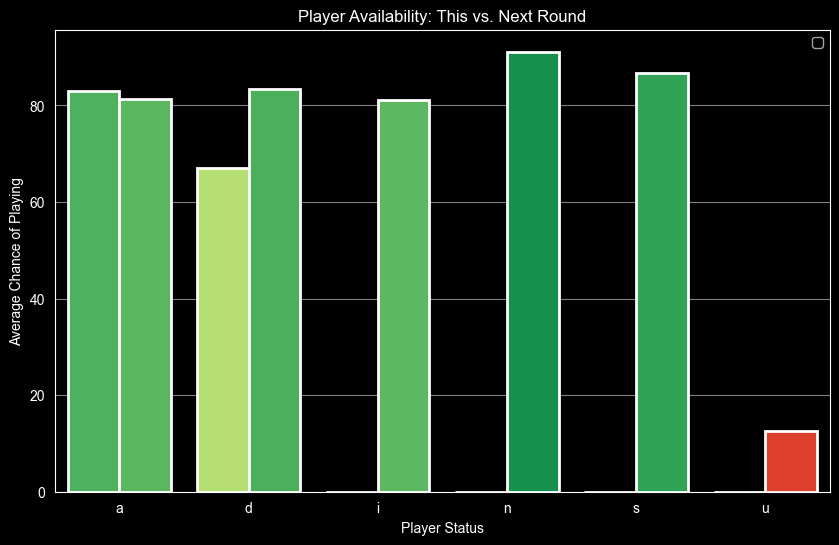

In [10]:
plt.figure(figsize=(10, 6))
plt.title("Player Availability: This vs. Next Round")
plt.legend("off")
ax = sns.barplot(data=change_of_playing.reset_index().melt("status"),
                 x="status", y="value", hue="variable", linewidth=2, edgecolor="white", legend=False)
[p.set_facecolor(plt.cm.RdYlGn(p.get_height()/100)) for p in ax.patches]
plt.xlabel("Player Status")
plt.ylabel("Average Chance of Playing")
plt.grid(axis="y", alpha=.5);

In [11]:
data.chance_of_playing_next_round.unique()

array([ nan,   0., 100.,  75.,  25.,  50.])

In [12]:
data.loc[data.status=="u", "chance_of_playing_next_round"] = 0

In [13]:
data.loc[data.chance_of_playing_next_round.isna(), "status"].unique()

<StringArray>
['a']
Length: 1, dtype: str

In [14]:
data.loc[(data['status'] == 'a') & (data['chance_of_playing_next_round'].isna()), 'chance_of_playing_next_round'] = 100
data.loc[(data['status'].isin(['i', 's', 'u', 'n'])) & (data['chance_of_playing_next_round'].isna()), 'chance_of_playing_next_round'] = 0
data.loc[(data['status'] == 'd') & (data['chance_of_playing_next_round'].isna()), 'chance_of_playing_next_round'] = 50

In [15]:
data['chance_of_playing_this_round'].isna().sum()

np.int64(6836)

In [16]:
data.loc[data.status=="a", 'chance_of_playing_this_round'] = 100
data.loc[(data.status == "d") & (data['chance_of_playing_this_round'].isna()), 'chance_of_playing_this_round'] = 50
data.loc[~data.status.isin(["a", "d"]), 'chance_of_playing_this_round'] = 0

In [17]:
s[s>.8]

corners_and_indirect_freekicks_order    0.843724
direct_freekicks_order                  0.871634
penalties_order                         0.888826
dtype: float64

In [18]:
s[s>.8].index

Index(['corners_and_indirect_freekicks_order', 'direct_freekicks_order',
       'penalties_order'],
      dtype='str')

In [19]:
def order_cols(df:pd.DataFrame,
               order_cols:List[str]=None)->pd.DataFrame:
  df = df.copy()

  if order_cols is None:
        return df

  for col in order_cols:
    if df[col].isna().sum() > 0:
      df.loc[df[col].isna(), col] = df[col].max() + 1
  return df

In [20]:
data = order_cols(df=data,
                  order_cols=s[s>.8].index)

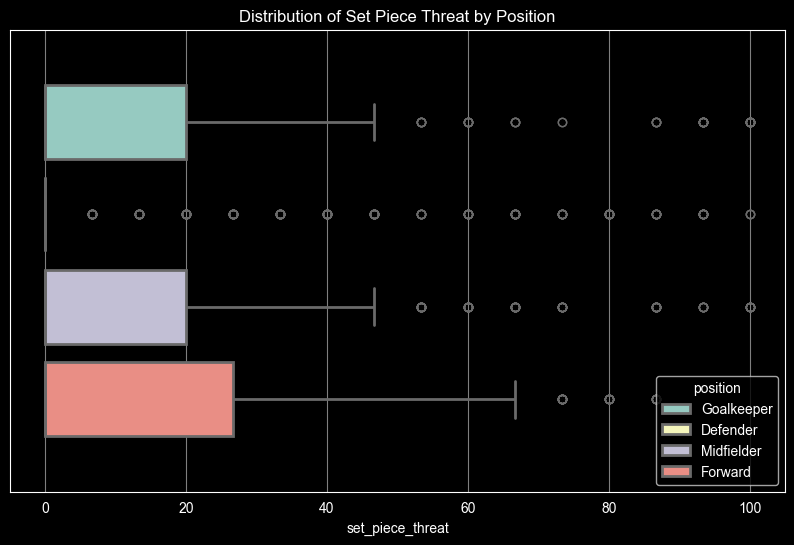

In [21]:
plt.figure(figsize=(10, 6))
plt.title("Distribution of Set Piece Threat by Position")
sns.boxplot(
    data=data,
    x="set_piece_threat",
    hue="position",
     linewidth=2,
    gap=.2)

plt.grid(axis="x", alpha=.5)
plt.show()

In [22]:
data.groupby("position")["set_piece_threat"].agg(lambda x: x.isna().mean())

position
Defender      0.709528
Forward       0.716790
Goalkeeper    0.638874
Midfielder    0.702497
Name: set_piece_threat, dtype: float64

In [23]:
data.set_piece_threat = data.set_piece_threat.fillna(0)

In [24]:
data.isna().sum()[data.isna().sum()>0].index

Index(['now_cost_rank_type', 'cost_change_event_fall',
       'cost_change_start_fall', 'selected_rank_type', 'points_per_game',
       'points_per_game_rank', 'points_per_game_rank_type', 'form_rank',
       'form_rank_type', 'dreamteam_count', 'expected_goals_per_90',
       'expected_assists_per_90', 'expected_goal_involvements_per_90',
       'expected_goals_conceded_per_90', 'influence_rank',
       'influence_rank_type', 'creativity_rank', 'creativity_rank_type',
       'threat_rank', 'threat_rank_type', 'ict_index_rank',
       'ict_index_rank_type'],
      dtype='str')

In [25]:
data_w_nan = data.copy()

In [26]:
data_w_nan = data_w_nan.assign(nan_flag = np.where(data_w_nan.isna().any(axis=1), 1, 0))

In [27]:
data_w_nan.dtypes.unique()

array([<StringDtype(storage='python', na_value=nan)>, dtype('int64'),
       dtype('float64'), dtype('bool')], dtype=object)

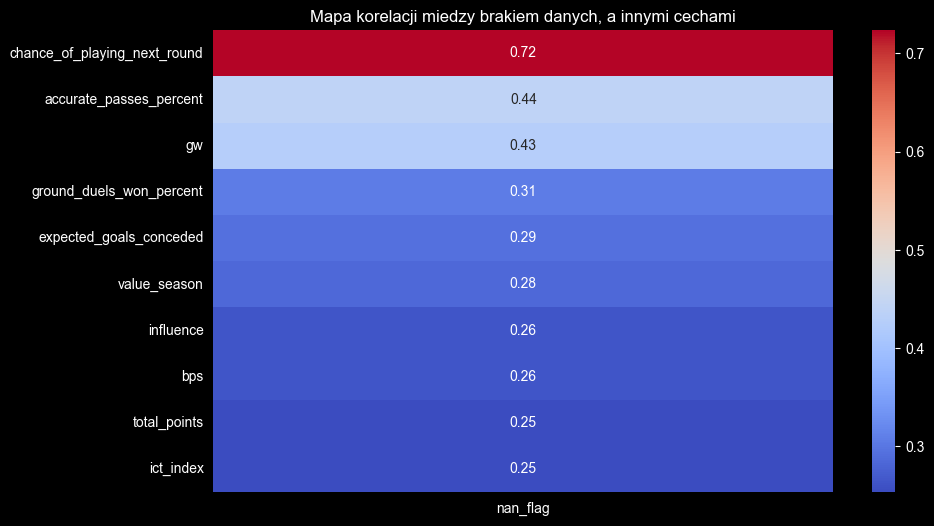

In [28]:
plt.figure(figsize=(10, 6))
plt.title("Mapa korelacji miedzy brakiem danych, a innymi cechami")
sns.heatmap(pd.DataFrame(data_w_nan.drop(columns=data_w_nan.select_dtypes(include=["object", "string"])).corr()\
                         .nan_flag.apply(np.abs).sort_values(ascending=False).dropna().head(11)).drop(["nan_flag"], axis=0),
            annot=True,
            cmap="coolwarm");


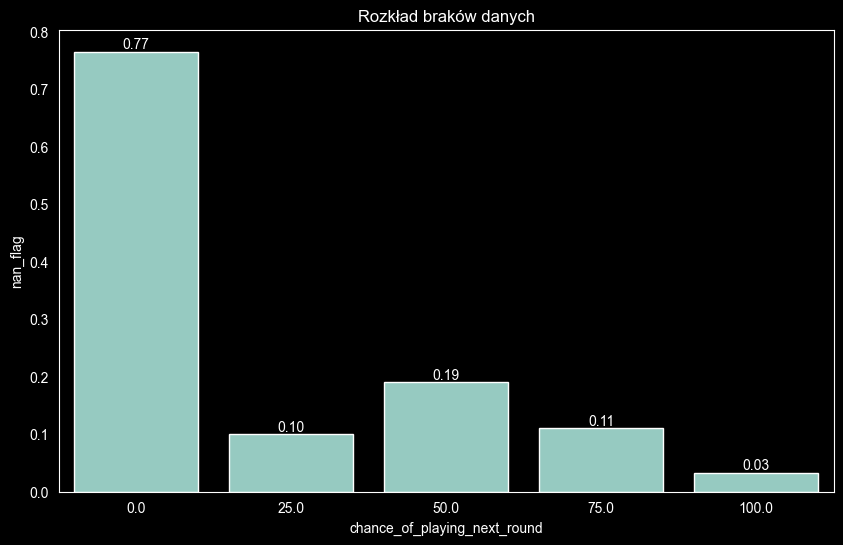

In [29]:
plt.figure(figsize=(10, 6))

ax = sns.barplot(data=data_w_nan, x="chance_of_playing_next_round", y="nan_flag", errorbar=None)

ax.bar_label(ax.containers[0], fmt='%.2f')

plt.title("Rozkład braków danych")
plt.grid(axis="y")
plt.show()

In [30]:
len(s[s<.2].index)

22

In [31]:
match_cols_to_impute = [c for c in s[s<.2].index if "rank"not in c]
len(match_cols_to_impute)
match_cols_to_impute

['cost_change_event_fall',
 'cost_change_start_fall',
 'points_per_game',
 'dreamteam_count',
 'expected_goals_per_90',
 'expected_assists_per_90',
 'expected_goal_involvements_per_90',
 'expected_goals_conceded_per_90']

In [32]:
rank_cols_to_impute = [c for c in s[s<.2].index if c not in match_cols_to_impute]
len(rank_cols_to_impute)

14

In [33]:
data = order_cols(df=data,
                  order_cols=rank_cols_to_impute)


In [34]:
data.dreamteam_count.unique()

array([ 0., nan,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.,
       12.])

In [35]:
data_w_nan.groupby("position").agg(lambda x: x.isna().sum())[match_cols_to_impute]

,cost_change_event_fall,cost_change_start_fall,points_per_game,dreamteam_count,expected_goals_per_90,expected_assists_per_90,expected_goal_involvements_per_90,expected_goals_conceded_per_90
position,,,,,,,,
Defender,840,840,840,840,840,840,840,840
Forward,273,273,273,273,273,273,273,273
Goalkeeper,161,161,161,161,161,161,161,161
Midfielder,1191,1191,1191,1191,1191,1191,1191,1191


In [36]:
data.head()

,season,status,player,position,kickoff_time,gw,player_id,minutes_played,goals,assists,total_shots,xg,xa,xgot,shots_on_target,successful_dribbles,big_chances_missed,touches_opposition_box,touches,accurate_passes,chances_created,final_third_passes,accurate_crosses,accurate_long_balls,tackles_won,interceptions,recoveries,blocks,clearances,headed_clearances,dribbled_past,duels_won,duels_lost,ground_duels_won,aerial_duels_won,was_fouled,fouls_committed,saves,goals_conceded,xgot_faced,goals_prevented,sweeper_actions,gk_accurate_passes,gk_accurate_long_balls,offsides,high_claim,tackles,accurate_passes_percent,accurate_crosses_percent,accurate_long_balls_percent,ground_duels_won_percent,aerial_duels_won_percent,successful_dribbles_percent,tackles_won_percent,start_min,finish_min,team_goals_conceded,penalties_scored,penalties_missed,finished,chance_of_playing_next_round,chance_of_playing_this_round,now_cost,now_cost_rank,now_cost_rank_type,cost_change_event,cost_change_event_fall,cost_change_start,cost_change_start_fall,selected_by_percent,selected_rank,selected_rank_type,total_points,y_points,points_per_game,points_per_game_rank,points_per_game_rank_type,bonus,bps,form,form_rank,form_rank_type,value_form,value_season,dreamteam_count,transfers_in,transfers_in_event,transfers_out,transfers_out_event,ep_next,ep_this,expected_goals,expected_assists,expected_goal_involvements,expected_goals_conceded,expected_goals_per_90,expected_assists_per_90,expected_goal_involvements_per_90,expected_goals_conceded_per_90,influence,influence_rank,influence_rank_type,creativity,creativity_rank,creativity_rank_type,threat,threat_rank,threat_rank_type,ict_index,ict_index_rank,ict_index_rank_type,corners_and_indirect_freekicks_order,direct_freekicks_order,penalties_order,set_piece_threat
0,2025-2026,a,Raya,Goalkeeper,2025-08-17 15:30:00,1,1,90,0,0,0,0.0,0.00,0.0,0,0,0,0,47,13,0.0,7,0,5,0,0,13,0,1,0,0,1,0,0,1,0,0,7,0,0.75,0.75,0,13,5,0,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,90,0,0,0,True,100.0,100.0,6.0,89,1.0,1,-1.0,5,-5.0,36.9,5,1.0,10,10,4.4,56.0,4.0,3,38,3.2,116.0,8.0,0.5,11.0,0.0,3072169,418466,1125554,56691,4.2,4.2,0.0,0.00,0.00,1.52,0.0,0.0,0.0,0.64,49.2,117.0,16.0,0.0,364.0,3.0,0.0,749.0,88.0,4.9,252.0,16.0,8.0,7.0,6.0,0.0
1,2025-2026,a,Raya,Goalkeeper,2025-08-23 16:30:00,2,1,90,0,0,0,0.0,0.00,0.0,0,0,0,0,34,28,0.0,4,0,6,0,0,3,0,0,0,0,0,0,0,0,0,0,1,0,0.14,0.14,0,28,6,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,90,0,0,0,True,0.0,100.0,5.5,130,359.0,0,NaN,0,NaN,21.5,18,344.0,16,6,NaN,801.0,303.0,3,66,8.0,805.0,341.0,1.5,2.9,NaN,354674,77335,120510,61830,7.5,9.0,0.0,0.00,0.00,1.69,NaN,NaN,NaN,NaN,62.6,774.0,343.0,0.0,806.0,331.0,0.0,807.0,345.0,6.2,778.0,342.0,8.0,7.0,6.0,0.0
2,2025-2026,a,Raya,Goalkeeper,2025-08-31 15:30:00,3,1,90,0,0,0,0.0,0.02,0.0,0,0,0,0,55,29,1.0,18,0,15,0,0,12,0,0,0,0,0,0,0,0,0,0,2,1,0.27,-0.73,1,29,15,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,90,1,0,0,True,0.0,100.0,5.5,132,359.0,0,NaN,0,NaN,21.8,17,344.0,18,2,NaN,801.0,303.0,3,78,6.0,805.0,341.0,1.1,3.3,NaN,462908,38830,235204,17474,6.5,5.5,0.0,0.02,0.02,2.21,NaN,NaN,NaN,NaN,82.6,774.0,343.0,10.0,806.0,331.0,0.0,807.0,345.0,9.2,778.0,342.0,8.0,7.0,6.0,0.0
3,2025-2026,a,Raya,Goalkeeper,2025-09-13 11:30:00,4,1,90,0,0,0,0.0,0.00,0.0,0,0,0,0,34,25,0.0,5,0,3,0,0,9,0,0,0,0,0,0,0,0,0,0,1,0,0.06,0.06,0,25,3,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,90,0,0,0,True,0.0,100.0,5.5,137,359.0,0,NaN,0,NaN,23.5,14,344.0,24,6,NaN,801.0,303.0,3,102,6.0,805.0,341.0,1.1,4.4,NaN,746262,33143,363824,28342,6.0,6.5,0.0,0.02,0.02,2.41,NaN,NaN,NaN,NaN,95.4,774.0,343.0,10.0,806.0,331.0,0.0,807.0,345.0,10.5,778.0,342.0,8.0,7.0,6.0,0.0
4,2025-2026,a,Raya,Goalkeeper,2025-09-21 15:30:00,5,1,90,0,0,0,0.0,0.01,0.0,0,0,0,0,39,25,0.0,10,0,7,0,0,6,0,1,0,0,1,0,1,0,1,0,2,1,1.11,0.11,0,25,7,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,90,1,0,0,True,0.0,100.0,5.5,138,359.0,0,NaN,0,NaN,24.0,15,344.0,26,2,NaN,801.0,303.0,3,115,4.0,805.0,341.0,0.7,4.7,NaN,907108,95889,475777,32409,4.0,4.0,0.0,0.03,0.03,3.30,NaN,NaN,NaN,NaN,116.8,774.0,343.0,10.0,806.0,331

In [37]:
def expected_features(df:pd.DataFrame, x_cols:List[str])->pd.DataFrame:
  df = df.copy()

  cols_per_90 = [f"{col}_per_90" for col in x_cols]
  df[cols_per_90] = df[x_cols].div(df['minutes_played'], axis=0).mul(90).fillna(0)

  return df

In [38]:
x_cols_to_drop = [c for c in match_cols_to_impute if "expected" in c]
x_cols_to_drop

['expected_goals_per_90',
 'expected_assists_per_90',
 'expected_goal_involvements_per_90',
 'expected_goals_conceded_per_90']

In [39]:
x_cols = ["xg", "xa", 'expected_goals_conceded', "expected_goal_involvements"]


In [40]:
data = expected_features(df=data,
                         x_cols=x_cols).drop(columns=x_cols_to_drop)


In [41]:
data.isna().sum()[data.isna().sum()>0]

cost_change_event_fall    2465
cost_change_start_fall    2465
points_per_game           2465
dreamteam_count           2465
dtype: int64

In [42]:
data.drop(columns=data.isna().sum()[data.isna().sum()>0].index, inplace=True)


In [43]:
data.isna().sum().sum()

np.int64(0)

In [44]:
data.duplicated().sum()

np.int64(0)

In [45]:
data.shape

(19312, 109)

In [47]:
filename = "../Data/FPL_data_24_26_cleaned.csv"
data.to_csv(filename, index=False)
